<a href="https://colab.research.google.com/github/toniskai/BH/blob/master/Predicci%C3%B3n%20de%20Demanda%20con%20SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade --force-reinstall numpy==1.25.2
!pip install --upgrade --force-reinstall pmdarima --no-cache-dir --no-binary :all:

  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.3/630.3 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
^C


Cargando y preparando datos...

Analizando estacionariedad...
ADF Statistic: -4.886152607449978
p-value: 3.710464850019485e-05
Critical Values: {'1%': -3.434899302257815, '5%': -2.8635492080466607, '10%': -2.567839687982253}

Buscando mejores parámetros con auto_arima...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9626.744, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=9043.458, Time=2.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=7.56 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9624.744, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=9495.164, Time=0.19 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=8886.272, Time=1.43 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=6.73 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=8686.310, Time=3.14 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=9233.878, Time=0.99 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=6.16 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AI

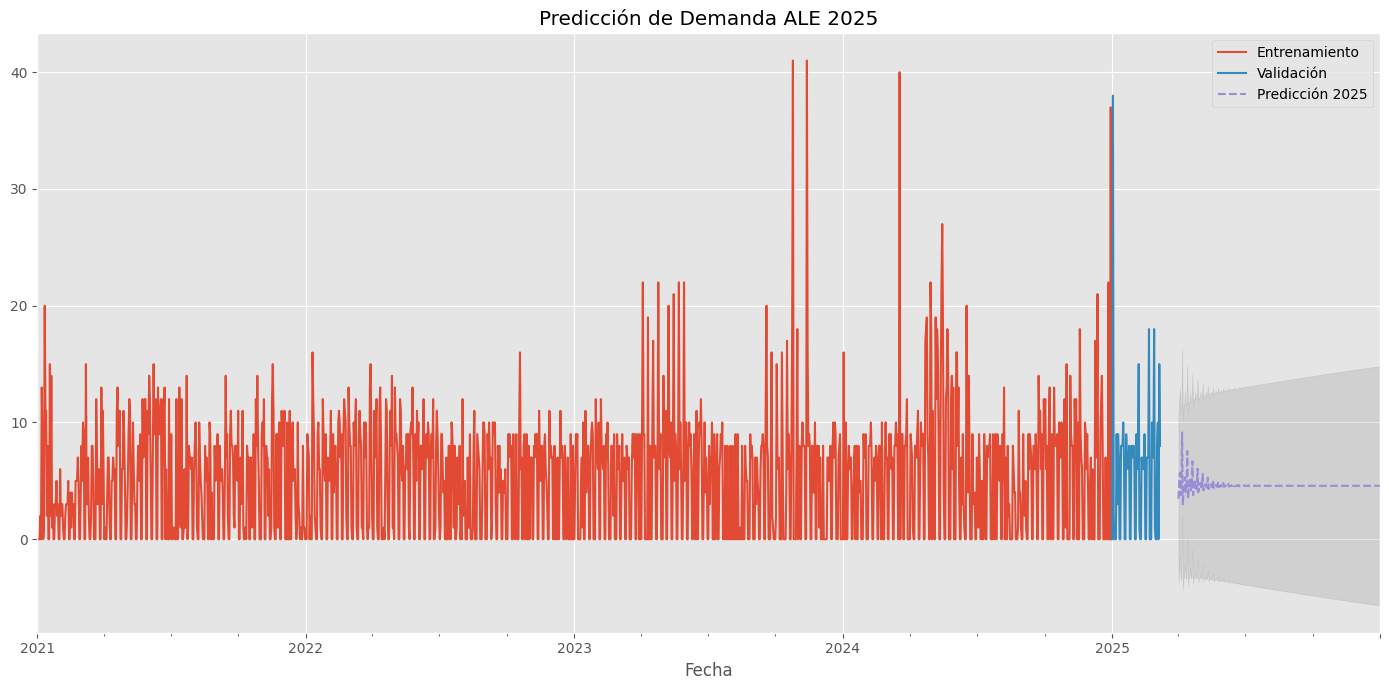


Exportando resultados...
Proceso completado exitosamente!


In [14]:
# -*- coding: utf-8 -*-
"""
Script completo para predicción de demanda del Servicio ALE con SARIMAX
Incluye:
1. Carga y preprocesamiento de datos
2. Búsqueda automática de parámetros óptimos
3. Validación cruzada temporal
4. Modelado SARIMAX con variables exógenas
5. Generación de predicciones y visualización
6. Exportación de resultados
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings('ignore')

# Configuración global
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)

# ======================
# 1. FUNCIONES AUXILIARES
# ======================

def load_and_preprocess(filepath):
    """Carga y preprocesa los datos"""
    df = pd.read_excel(filepath, sheet_name='Hoja1')

    # Procesamiento básico
    df['FSol_Eje'] = pd.to_datetime(df['FSol_Eje'])
    df.set_index('FSol_Eje', inplace=True)
    df = df[['NumSolicitudes', 'DiaSemana', 'finDeSemana',
             'festivoNacional', 'festivoLocal', 'Verano', 'Mes']]

    # Codificación de variables
    df = pd.get_dummies(df, columns=['DiaSemana', 'Mes'], drop_first=True)

    # Convert all columns to numeric type, coerce errors to NaN
    # --- This line is modified to ensure all data is numeric ---
    df = df.apply(pd.to_numeric, errors='coerce').astype(float)

    return df

def test_stationarity(series):
    """Prueba de estacionariedad Dickey-Fuller"""
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    return result[1]  # Retorna p-value

def find_best_arima(train_data, exog_data):
    """Búsqueda automática de parámetros SARIMAX"""
    print("\nBuscando mejores parámetros con auto_arima...")
    auto_model = auto_arima(
        train_data,
        exogenous=exog_data,
        start_p=0, max_p=3,
        start_q=0, max_q=3,
        d=None,  # Busca automáticamente
        start_P=0, max_P=2,
        start_Q=0, max_Q=2,
        D=None,  # Busca automáticamente
        m=7,  # Estacionalidad semanal
        seasonal=True,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        n_jobs=-1
    )
    print(auto_model.summary())
    return auto_model.order, auto_model.seasonal_order

def time_series_cv(train_data, exog_data, order, seasonal_order, n_splits=5):
    """Validación cruzada temporal"""
    print("\nRealizando validación cruzada...")
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []

    for train_idx, test_idx in tscv.split(train_data):
        cv_train = train_data.iloc[train_idx]
        cv_test = train_data.iloc[test_idx]
        cv_exog_train = exog_data.iloc[train_idx]
        cv_exog_test = exog_data.iloc[test_idx]

        try:
            model = SARIMAX(cv_train,
                          exog=cv_exog_train,
                          order=order,
                          seasonal_order=seasonal_order)
            results = model.fit(disp=False)

            pred = results.get_forecast(steps=len(cv_test),
                                      exog=cv_exog_test).predicted_mean
            rmse_scores.append(rmse(cv_test, pred))
        except:
            continue

    print(f"RMSE promedio: {np.mean(rmse_scores):.2f}")
    print(f"Desviación estándar: {np.std(rmse_scores):.2f}")
    return rmse_scores

# ======================
# 2. FLUJO PRINCIPAL
# ======================

def main():
    # 1. Carga y preparación de datos
    print("Cargando y preparando datos...")
    df = load_and_preprocess('/content/Demanda ALE v2.xlsx')
    train = df.loc[:'2024-12-31']
    test = df.loc['2025-01-01':'2025-03-31']

    # 2. Análisis de estacionariedad
    print("\nAnalizando estacionariedad...")
    p_value = test_stationarity(train['NumSolicitudes'])

    # 3. Búsqueda de mejores parámetros
    exog_train = train.drop('NumSolicitudes', axis=1)
    best_order, best_seasonal_order = find_best_arima(
        train['NumSolicitudes'], exog_train)

    # 4. Validación cruzada
    cv_scores = time_series_cv(
        train['NumSolicitudes'],
        exog_train,
        best_order,
        best_seasonal_order
    )

    # 5. Entrenamiento del modelo final
    print("\nEntrenando modelo final...")
    final_model = SARIMAX(
        train['NumSolicitudes'],
        exog=exog_train,
        order=best_order,
        seasonal_order=best_seasonal_order
    ).fit(disp=False)

    print(final_model.summary())

    # 6. Predicciones
    print("\nGenerando predicciones...")
    future_dates = pd.date_range('2025-04-01', '2025-12-31')

    # Preparar datos exógenos futuros (ejemplo simplificado)
    future_df = pd.DataFrame(index=future_dates)
    for col in exog_train.columns:
        future_df[col] = exog_train[col].median()  # Usar valores medios

    # Generar predicciones
    predictions = final_model.get_forecast(
        steps=len(future_dates),
        exog=future_df
    )

    # 7. Resultados y visualización
    results_df = pd.DataFrame({
        'Fecha': future_dates,
        'Prediccion': predictions.predicted_mean,
        'Limite_Inferior': predictions.conf_int().iloc[:, 0],
        'Limite_Superior': predictions.conf_int().iloc[:, 1]
    }).set_index('Fecha')

    # Visualización
    plt.figure(figsize=(14, 7))
    train['NumSolicitudes'].plot(label='Entrenamiento')
    test['NumSolicitudes'].plot(label='Validación')
    results_df['Prediccion'].plot(label='Predicción 2025', style='--')
    plt.fill_between(results_df.index,
                    results_df['Limite_Inferior'],
                    results_df['Limite_Superior'],
                    color='gray', alpha=0.2)
    plt.title('Predicción de Demanda ALE 2025')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 8. Exportación de resultados
    print("\nExportando resultados...")
    with pd.ExcelWriter('Prediccion_ALE_2025_Mejorada.xlsx') as writer:
        results_df.reset_index().to_excel(
            writer, sheet_name='Predicciones', index=False)

        summary_data = {
            'Mejores Parámetros': [str(best_order), str(best_seasonal_order)],
            'RMSE Validación Cruzada': [np.mean(cv_scores), np.std(cv_scores)],
            'Estacionariedad (p-value)': [p_value, '']
        }
        pd.DataFrame(summary_data).to_excel(
            writer, sheet_name='Resumen', index=False)

    print("Proceso completado exitosamente!")

if __name__ == "__main__":
    main()